In [1]:
import torch 
from smartem.offline.train_mb_error_detector.NNtools import UNet as UNet_offline
from smartem.online.models.UNet import UNet as UNet_online
import matplotlib.pyplot as plt
import numpy as np

In [2]:
weights_path = "/home/tommy-local/projects/smartem/SmartEM/pretrained_models/em2mb_best_core.pth"
torch.manual_seed(0)
#torch.use_deterministic_algorithms(True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

em2mb_net = UNet_online(1, 2)
em2mb_net.load_state_dict(torch.load(weights_path))
em2mb_net.eval()
em2mb_net.to(device)
print()

# Image size

In [ ]:
im_ref = torch.randn((1, 1, 3072, 2048), device=device, dtype=torch.float32)
out_ref = em2mb_net(im_ref).cpu().detach().numpy()

# Modify image of same size to have the same center as the reference

In [ ]:
im_ref = torch.randn((1, 1, 1024, 1024), device=device, dtype=torch.float32)
out_ref = em2mb_net(im_ref).cpu().detach().numpy()
out_ref = np.squeeze(out_ref[0,0,:,:])

for r in range(50, 200, 50):
    im_rand = torch.randn((1, 1, 1024, 1024), device=device, dtype=torch.float32)
    im_rand[:,:,512-r:512+r,512-r:512+r] = im_ref[:,:,512-r:512+r,512-r:512+r]
    out_rand = em2mb_net(im_rand).cpu().detach().numpy()
    out_rand = np.squeeze(out_rand[0,0,:,:])

    if r > 100:
        sum = np.sum(out_ref == out_rand, axis=0)
        equal_idxs = np.where(sum > 20)[0]
    else:
        equal_idxs = [np.nan, np.nan]

    f, axs = plt.subplots(ncols=3)
    axs[0].imshow(out_ref)
    axs[1].imshow(out_rand)
    axs[2].imshow(out_ref == out_rand)
    plt.title(f"EM2MB: radius = {r} {(equal_idxs[0], equal_idxs[-1])}")
    plt.show()




# Crop the center of the reference

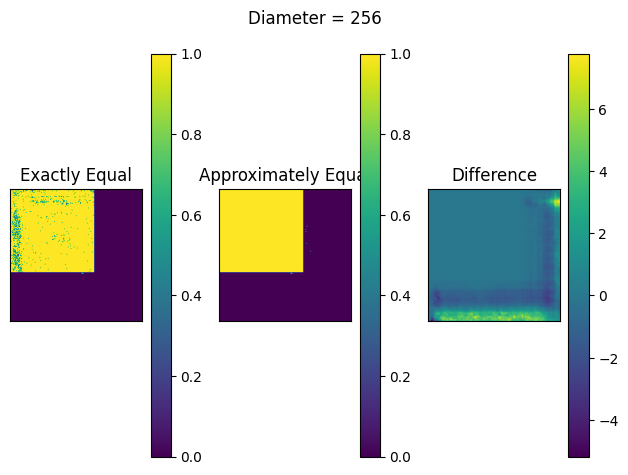

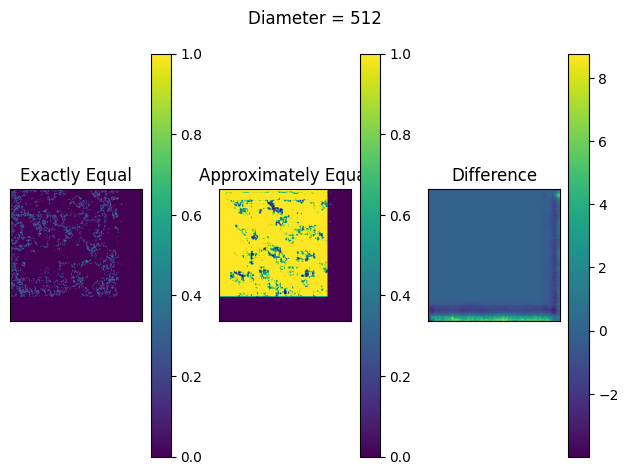

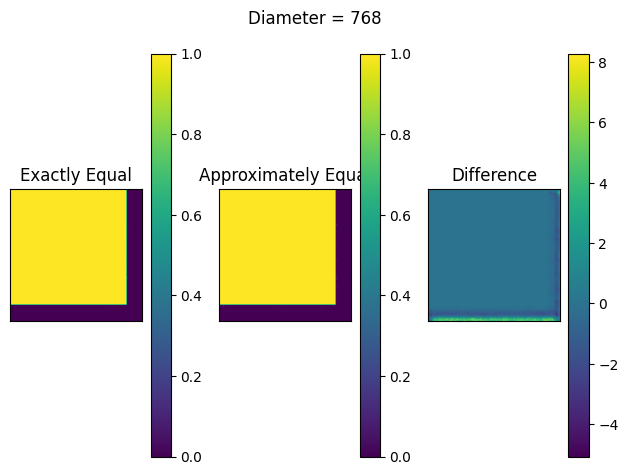

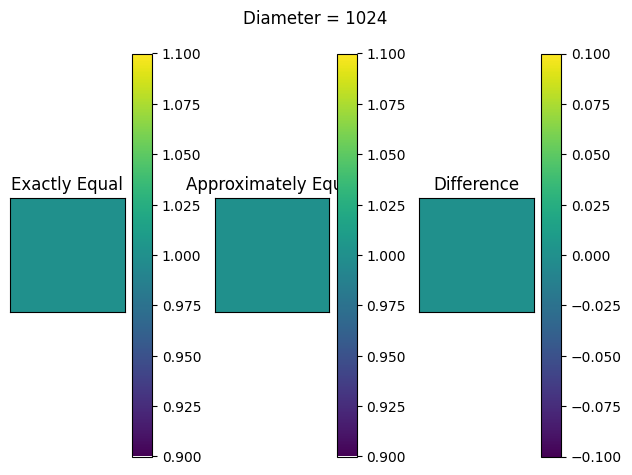

In [6]:
im_ref = torch.randn((1, 1, 1024, 1024), device=device, dtype=torch.float32)

for r in range(128, 513, 128):
    im_crop = im_ref[:,:,:2*r,:2*r]
    
    out_ref = em2mb_net(im_ref).cpu().detach().numpy()
    out_crop = em2mb_net(im_crop).cpu().detach().numpy()
    out_ref_crop = out_ref[:,:,:2*r,:2*r]

    out_crop = out_crop[0,0,:,:]
    out_ref_crop = out_ref_crop[0,0,:,:]

    f, ax = plt.subplots(ncols=3)
    eq_plot = ax[0].imshow(out_ref_crop == out_crop)
    ax[0].set_title("Exactly Equal")
    f.colorbar(eq_plot, ax=ax[0])
    eq_plot = ax[1].imshow(np.isclose(out_ref_crop, out_crop))
    ax[1].set_title("Approximately Equal")
    f.colorbar(eq_plot, ax=ax[1])
    im_plot = ax[2].imshow(out_ref_crop - out_crop)
    ax[2].set_title("Difference")
    f.colorbar(im_plot, ax=ax[2])
    
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    f.suptitle(f"Diameter = {2*r}")
    f.tight_layout()
    plt.show()




Pytorch uses nondeterministic algorithms for performance e.g. a simple 2d convolution is not deterministic as shown below. https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html#torch.use_deterministic_algorithms

torch.Size([1, 64, 1024, 1024])
torch.Size([1, 64, 256, 256])


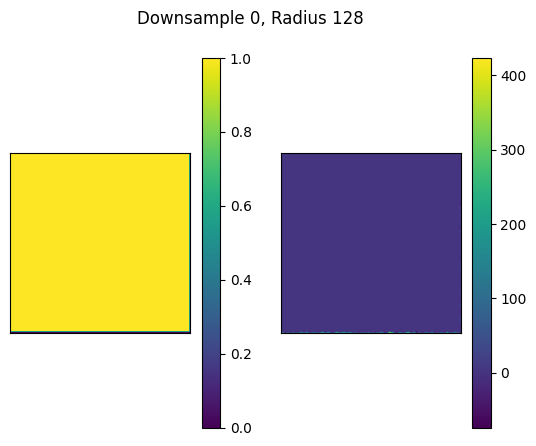

torch.Size([1, 128, 512, 512])
torch.Size([1, 128, 128, 128])


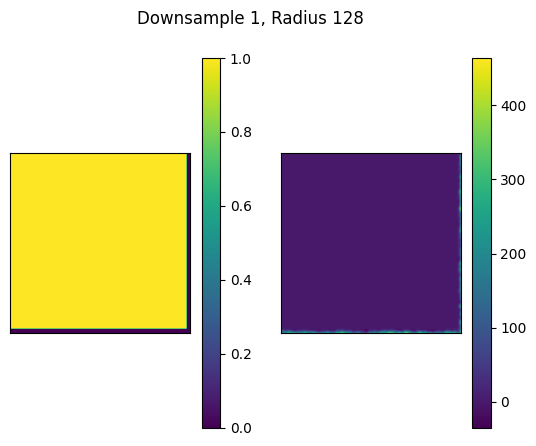

torch.Size([1, 256, 256, 256])
torch.Size([1, 256, 64, 64])


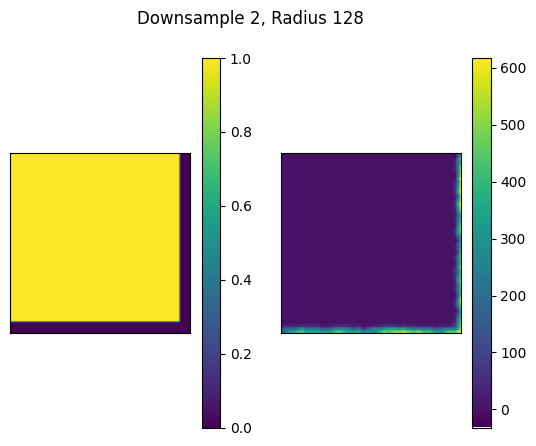

torch.Size([1, 512, 128, 128])
torch.Size([1, 512, 32, 32])


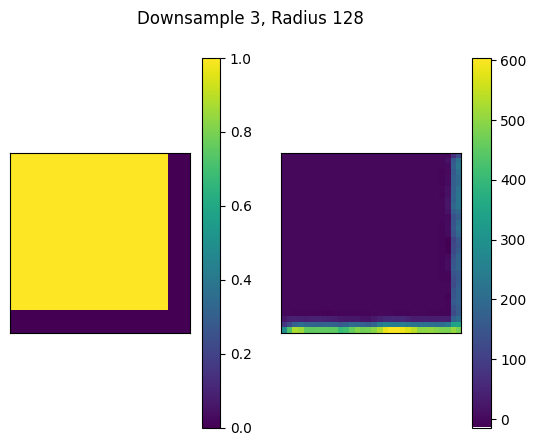

torch.Size([1, 1024, 64, 64])
torch.Size([1, 1024, 16, 16])


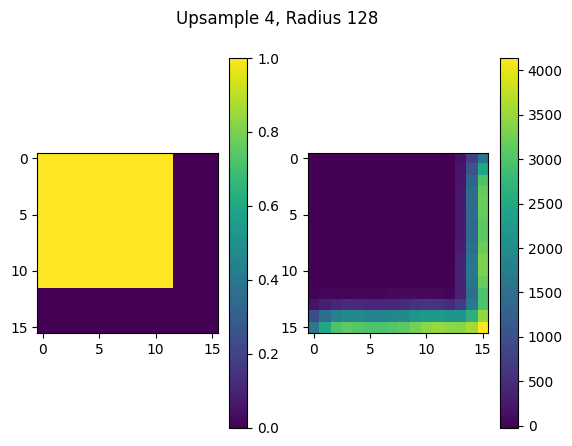

torch.Size([1, 512, 128, 128])
torch.Size([1, 512, 32, 32])


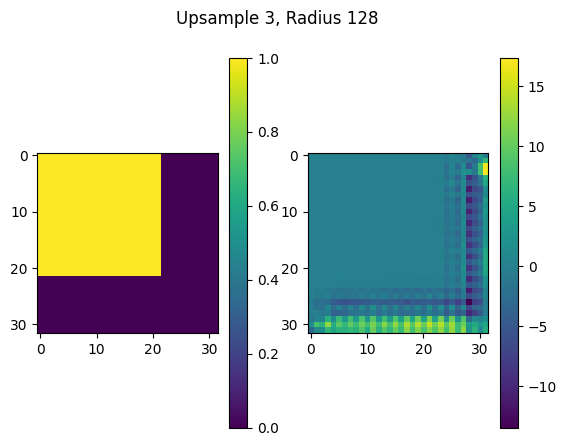

torch.Size([1, 256, 256, 256])
torch.Size([1, 256, 64, 64])


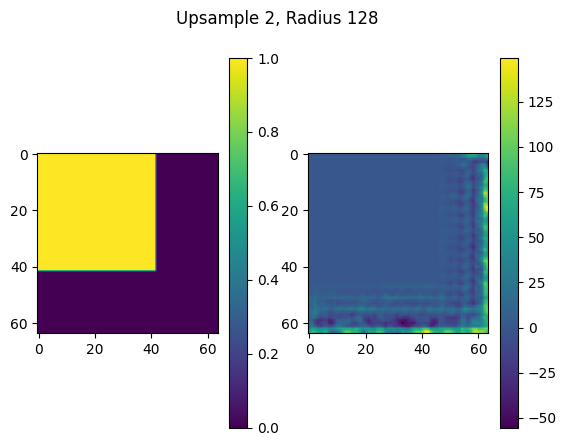

torch.Size([1, 128, 512, 512])
torch.Size([1, 128, 128, 128])


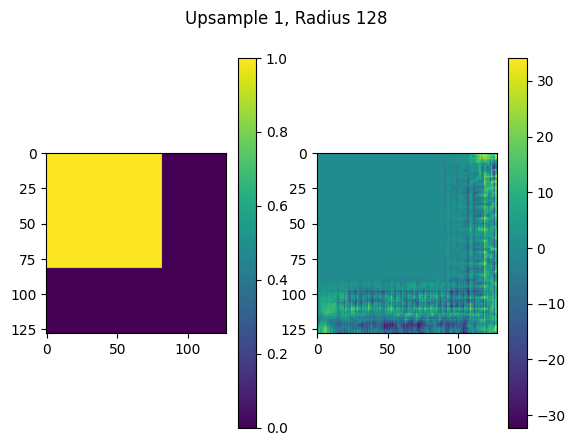

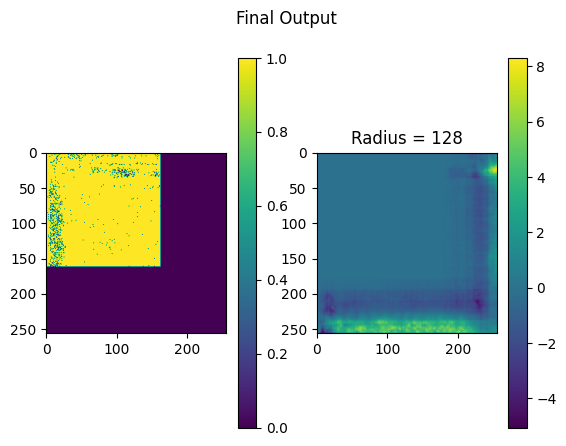

In [3]:
im_ref = torch.randn((1, 1, 1024, 1024), device=device, dtype=torch.float32)
out_ref = em2mb_net(im_ref).cpu().detach().numpy()
out_ref = np.squeeze(out_ref[0,0,:,:])

for r in range(128, 513, 128):
    im_crop = im_ref[:,:,:2*r,:2*r]

    acts_ref = []
    acts_crop = []

    acts_ref.append(em2mb_net.inc(im_ref))
    acts_crop.append(em2mb_net.inc(im_crop))

    ds_factors = [i for i in range(4)]

    for i, layer in zip(ds_factors, [em2mb_net.down1, em2mb_net.down2, em2mb_net.down3, em2mb_net.down4]):
        cur_act_ref = acts_ref[-1]
        cur_act_crop = acts_crop[-1]
        print(cur_act_ref.shape)
        print(cur_act_crop.shape)

        plot_ref = np.squeeze(cur_act_ref.cpu().detach().numpy())[:,:2*r//2**i,:2*r//2**i]
        plot_crop = np.squeeze(cur_act_crop.cpu().detach().numpy())
        plot_ref = np.sum(plot_ref, axis=0)
        plot_crop = np.sum(plot_crop, axis=0)
        f, ax = plt.subplots(ncols=2)
        eq_plot = ax[0].imshow(plot_ref == plot_crop)
        f.colorbar(eq_plot, ax=ax[0])
        im_plot = ax[1].imshow(plot_ref - plot_crop)
        f.colorbar(im_plot, ax=ax[1])
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])
        plt.suptitle(f"Downsample {i}, Radius {r}")
        plt.show()

        acts_ref.append(layer(cur_act_ref))
        acts_crop.append(layer(cur_act_crop))
    
    ds_factors = [4, 3, 2, 1]
    for i, layer in zip(ds_factors, [em2mb_net.up1, em2mb_net.up2, em2mb_net.up3, em2mb_net.up4]):
        cur_act_ref = acts_ref[-1]
        cur_act_crop = acts_crop[-1]
        print(cur_act_ref.shape)
        print(cur_act_crop.shape)

        plot_ref = np.squeeze(cur_act_ref.cpu().detach().numpy())[:,:2*r//2**i,:2*r//2**i]
        plot_crop = np.squeeze(cur_act_crop.cpu().detach().numpy())
        plot_ref = np.sum(plot_ref, axis=0)
        plot_crop = np.sum(plot_crop, axis=0)
        f, ax = plt.subplots(ncols=2)
        eq_plot = ax[0].imshow(plot_ref == plot_crop)
        f.colorbar(eq_plot, ax=ax[0])
        im_plot = ax[1].imshow(plot_ref - plot_crop)
        f.colorbar(im_plot, ax=ax[1])
        # for a in ax:
        #     a.set_xticks([])
        #     a.set_yticks([])
        plt.suptitle(f"Upsample {i}, Radius {r}")
        plt.show()

        acts_ref.append(layer(cur_act_ref, acts_ref[i-1]))
        acts_crop.append(layer(cur_act_crop, acts_crop[i-1]))
    
    final_act_ref = acts_ref[-1]
    final_act_crop = acts_crop[-1]
    assert torch.all(final_act_ref[:,:,:50,:50] == final_act_crop[:,:,:50,:50])
    out_ref = em2mb_net.outc(final_act_ref)#.cpu().detach().numpy()
    out_crop = em2mb_net.outc(final_act_crop)#.cpu().detach().numpy()
    assert torch.allclose(out_ref[:,:,:50,:50], out_crop[:,:,:50,:50])
    #assert torch.all(out_ref[:,:,:50,:50] == out_crop[:,:,:50,:50])
    out_ref = out_ref.cpu().detach().numpy()
    out_crop = out_crop.cpu().detach().numpy()
    assert np.allclose(out_ref[:,:,:50,:50], out_crop[:,:,:50,:50])

    out_ref_crop = out_ref[:,:,:2*r,:2*r]

    out_crop = out_crop[0,0,:,:]
    out_ref_crop = out_ref_crop[0,0,:,:]

    f, ax = plt.subplots(ncols=2)
    eq_plot = ax[0].imshow(out_ref_crop == out_crop)
    f.colorbar(eq_plot, ax=ax[0])
    im_plot = ax[1].imshow(out_ref_crop - out_crop)
    f.colorbar(im_plot, ax=ax[1])
    # for a in ax:
    #     a.set_xticks([])
    #     a.set_yticks([])
    plt.suptitle("Final Output")
    plt.title(f"Radius = {r}")
    plt.show()

    break


